Abstract

[**hdf5plugin**](https://github.com/silx-kit/hdf5plugin) is a *Python* package (1) providing a set of [**HDF5**](https://portal.hdfgroup.org/display/HDF5/) compression filters (namely: blosc, bitshuffle, lz4, FCIDECOMP, ZFP, Zstandard) and (2) enabling their use from the *Python* programming language with [**h5py**](https://docs.h5py.org/) a thin, pythonic wrapper around `libHDF5`.

This presentation illustrates how to use **hdf5plugin** for reading and writing compressed datasets from *Python* and gives an overview of the different HDF5 compression filters it provides.

License: [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)

In [ ]:
# Notebook requirements
# A recent version of Pillow is required!
#%pip install numpy h5py hdf5plugin h5glance rise jupyterlab matplotlib ipympl Pillow

In [ ]:
%matplotlib inline

# Creates data.h5 used for demos
from matplotlib import pyplot as plt
import h5py
import hdf5plugin
import numpy
from PIL import Image
import urllib.request

url = "https://www.iter.org/doc/www/content/com/Lists/WebText_2014/Attachments/236/platform_view_north_1.jpg"
filename = urllib.request.urlretrieve(url)[0]
image = numpy.array(Image.open(filename).convert("L"))
plt.imshow(image)

h5file = h5py.File("data.h5", mode="w")
h5file["copyright"] = "ITER"
h5file.attrs["url"] = url
h5file.create_dataset("/data", data=image)
h5file.create_dataset(
    "/compressed_data",
    data=image,
    **hdf5plugin.Blosc('lz4', shuffle=hdf5plugin.Blosc.BITSHUFFLE)
)
h5file.close()

**Restart kernel once the file is created!**

In [ ]:
import os
os._exit(0)  # Makes the kernel restart

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

def imshow(image):
    plt.imshow(image)
    plt.colorbar()

![ESRF logo](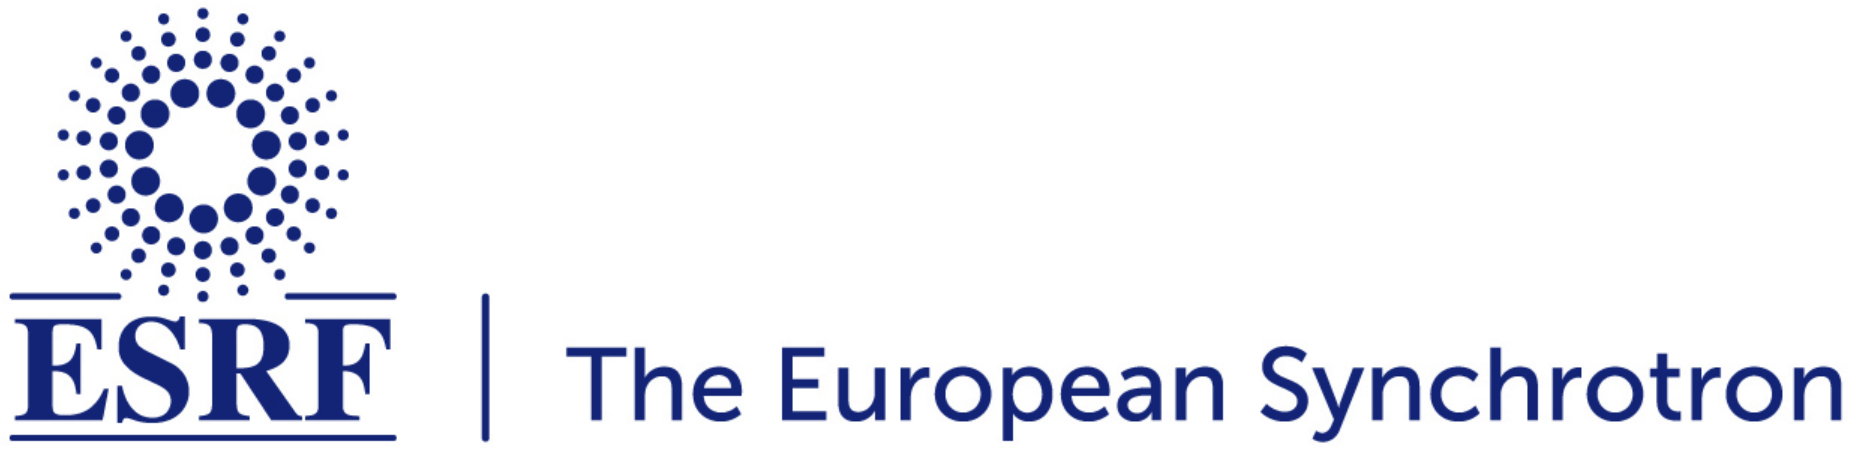 "ESRF logo")

# hdf5plugin

[**hdf5plugin**](https://github.com/silx-kit/hdf5plugin) packages a set of [HDF5](https://portal.hdfgroup.org/display/HDF5/) compression filters (namely: blosc, bitshuffle, lz4, FCIDECOMP, ZFP, Zstandard) and makes them usable from the Python programming language through [h5py](https://docs.h5py.org/).

[**h5py**](https://docs.h5py.org/) is a thin, pythonic wrapper around [HDF5](https://portal.hdfgroup.org/display/HDF5/).

&nbsp;

&nbsp;

Presenter: Thomas VINCENT

European HDF5 User Group Meeting 2022, May 31, 2022

In [2]:
from h5glance import H5Glance  # Browsing HDF5 files
H5Glance("data.h5")

data.h5/ (1 attributes)
├compressed_data	[uint8: 1542 × 2500]
├copyright	[UTF-8 string: scalar]
└data	[uint8: 1542 × 2500]

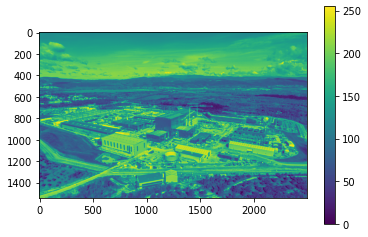

In [3]:
import h5py  # Pythonic HDF5 wrapper: https://docs.h5py.org/

h5file = h5py.File("data.h5", mode="r")  # Open HDF5 file in read mode
data = h5file["/data"][()]               # Access HDF5 dataset "/data"
imshow(data)                             # Display data

In [4]:
data = h5file["/compressed_data"][()]  # Access compressed dataset

OSError: Can't read data (can't open directory: /usr/local/hdf5/lib/plugin)

In [5]:
# Check dataset's filters
plist = h5file["/compressed_data"].id.get_create_plist()
plist.get_filter(0)[0::3]

(32001, b'blosc')

## `hdf5plugin` usage

### Reading compressed datasets

To enable reading compressed datasets not supported by `libHDF5` and `h5py`:
Install **hdf5plugin** & import it.

In [ ]:
%%bash
pip3 install hdf5plugin

Or: `conda install -c conda-forge hdf5plugin`

In [6]:
import hdf5plugin

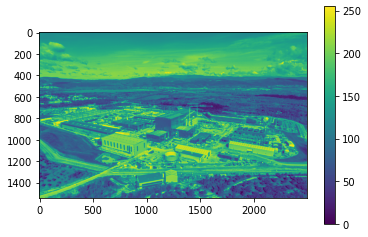

In [7]:
data = h5file["/compressed_data"][()]  # Access datset
imshow(data)                           # Display data

In [8]:
h5file.close()  # Close the HDF5 file

### Writing compressed datasets

When writing datasets with `h5py`, compression can be specified with: [h5py.Group.create_dataset](https://docs.h5py.org/en/stable/high/group.html?highlight=create_dataset#h5py.Group.create_dataset)

In [9]:
# Create a dataset with h5py without compression
h5file = h5py.File("new_file_uncompressed.h5", mode="w")
h5file.create_dataset("/data", data=data)
h5file.close()

In [10]:
# Create a compressed dataset
h5file = h5py.File("new_file_blosc_bitshuffle_lz4.h5", mode="w")
h5file.create_dataset(
    "/compressed_data",
    data=data,
    compression=32001,  # blosc HDF5 filter identifier
    # options: 0, 0, 0, 0, level, shuffle, compression
    compression_opts=(0, 0, 0, 0, 5, 2, 1)  
)
h5file.close()

`hdf5plugin` provides some [helpers](http://www.silx.org/doc/hdf5plugin/latest/usage.html#write-compressed-datasets) to ease dealing with compression filter and options:

In [11]:
h5file = h5py.File("new_file_blosc_bitshuffle_lz4.h5", mode="w")
h5file.create_dataset(
    "/compressed_data",
    data=data,
    **hdf5plugin.Blosc(
        cname='lz4',
        clevel=5,
        shuffle=hdf5plugin.Blosc.BITSHUFFLE),
)
h5file.close()

In [12]:
help(hdf5plugin.Blosc)

Help on class Blosc in module hdf5plugin:

class Blosc(h5py._hl.filters.FilterRefBase)
 |  Blosc(cname='lz4', clevel=5, shuffle=1)
 |  
 |  ``h5py.Group.create_dataset``'s compression arguments for using blosc filter.
 |  
 |  It can be passed as keyword arguments:
 |  
 |  .. code-block:: python
 |  
 |      f = h5py.File('test.h5', 'w')
 |      f.create_dataset(
 |          'blosc_byte_shuffle_blosclz',
 |          data=numpy.arange(100),
 |          **hdf5plugin.Blosc(cname='blosclz', clevel=9, shuffle=hdf5plugin.Blosc.SHUFFLE))
 |      f.close()
 |  
 |  :param str cname:
 |      `blosclz`, `lz4` (default), `lz4hc`, `zlib`, `zstd`
 |      Optional: `snappy`, depending on compilation (requires C++11).
 |  :param int clevel:
 |      Compression level from 0 (no compression) to 9 (maximum compression).
 |      Default: 5.
 |  :param int shuffle: One of:
 |      - Blosc.NOSHUFFLE (0): No shuffle
 |      - Blosc.SHUFFLE (1): byte-wise shuffle (default)
 |      - Blosc.BITSHUFFLE (2): bi

In [13]:
H5Glance("new_file_blosc_bitshuffle_lz4.h5")

new_file_blosc_bitshuffle_lz4.h5/
└compressed_data	[uint8: 1542 × 2500]

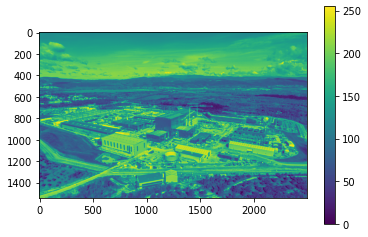

In [14]:
h5file = h5py.File("new_file_blosc_bitshuffle_lz4.h5", mode="r")
imshow(h5file["/compressed_data"][()])
h5file.close()

In [1]:
!ls -sh new_file*.h5

3.4M new_file_blosc_bitshuffle_lz4.h5  3.7M new_file_uncompressed.h5


## HDF5 compression filters

### Available through `h5py`

[Compression filters provided by h5py](https://docs.h5py.org/en/stable/high/dataset.html#lossless-compression-filters):

- Provided by `libhdf5`: **"gzip"** and eventually **"szip"** (optional)
- Bundled with `h5py`: [**"lzf"**](https://confluence.hdfgroup.org/display/support/Filters#Filters-32000)

Pre-compression filter: [Byte-Shuffle](https://docs.h5py.org/en/stable/high/dataset.html#shuffle-filter)

In [16]:
h5file = h5py.File("new_file_shuffle_gzip.h5", mode="w")
h5file.create_dataset(
    "/compressed_data_shuffle_gzip", data=data, shuffle=True, compression="gzip")
h5file.close()

### Provided by `hdf5plugin`

Additional compression filters provided by `hdf5plugin`: Bitshuffle, Blosc, FciDecomp, LZ4, ZFP, Zstandard.

6 out of the 28 [HDF5 registered filter plugins](https://confluence.hdfgroup.org/display/support/Registered+Filter+Plugins) as of May 2022.

In [17]:
h5file = h5py.File("new_file_bitshuffle_lz4.h5", mode="w")
h5file.create_dataset(
    "/compressed_data_bitshuffle_lz4",
    data=data,
    **hdf5plugin.Bitshuffle()
)
h5file.close()

#### General purpose lossless compression

- [Bitshuffle(nelems=0, lz4=True)](http://www.silx.org/doc/hdf5plugin/latest/usage.html#bitshuffle) (Filter ID [32008](https://confluence.hdfgroup.org/display/support/Filters#Filters-32008)): **Bit**-Shuffle + LZ4
- [LZ4(nbytes=0)](http://www.silx.org/doc/hdf5plugin/latest/usage.html#lz4) (Filter ID [32004](https://confluence.hdfgroup.org/display/support/Filters#Filters-32004))
- [Zstd(clevel=3)](http://www.silx.org/doc/hdf5plugin/latest/usage.html#zstd) (Filter ID [32015](https://confluence.hdfgroup.org/display/support/Filters#Filters-32015))
- [Blosc(cname='lz4', clevel=5, shuffle=1)](http://www.silx.org/doc/hdf5plugin/latest/usage.html#blosc) (Filter ID [32001](https://confluence.hdfgroup.org/display/support/Filters#Filters-32001)):
  Based on c-blosc: A blocking, shuffling and lossless compression library.
  - Pre-compression shuffle: None, **Byte**-Shuffle, **Bit**-Shuffle
  - Compression: `blosclz`, `lz4`, `lz4hc`, `snappy` (**optional**, requires C++11), `zlib`, `zstd`

#### Equivalent filters

`Blosc` includes pre-compression filters and algorithms provided by other HDF5 compression filters:

- HDF5 shuffle  => `Blosc(..., shuffle=Blosc.SHUFFLE)`
- `Bitshuffle()` => `Blosc("lz4", 5, Blosc.BITSHUFFLE)`
- `LZ4()` => `Blosc("lz4", 9)`
- `Zstd()` => `Blosc("zstd", 2)`

#### Specific compression

- [FciDecomp()](http://www.silx.org/doc/hdf5plugin/latest/usage.html#fcidecomp) (Filter ID [32018](https://confluence.hdfgroup.org/display/support/Filters#Filters-32018)): Based on JPEG-LS:
  - **Optional**: requires C++11
  - Data type: `(u)int8` or `(u)int16`
  - Chunk shape: "Image-like"; 2 or 3 dimensions with at least 16 pixels and at most 65535 rows and columns and at most 4 planes for 3D datasets.
- [ZFP(rate=None, precision=None, accuracy=None, reversible=False, minbits=None, maxbits=None, maxprec=None, minexp=None)](http://www.silx.org/doc/hdf5plugin/latest/usage.html#zfp) (Filter ID [32013](https://confluence.hdfgroup.org/display/support/Filters#Filters-32013)): **Lossy**
  - Data type: `float32`, `float64`, `(u)int32`, `(u)int64`
  - Chunk shape: must have at most 4 non-unity dimensions

#### A look at performances on a single use case

- Machine: Intel(R) Xeon(R) Gold 6248 CPU @ 2.50GHz (40 cores)
- Filesystem: /dev/shm
- `hdf5plugin` built from source


- Running on a single thread (with `OMP_NUM_THREADS=1`)


- Diffraction tomography dataset: 100 frames from http://www.silx.org/pub/pyFAI/pyFAI_UM_2020/data_ID13/kevlar.h5
- Dataset: 100x2167x2070, uint16, chunk: 2167x2070

![Benchmark](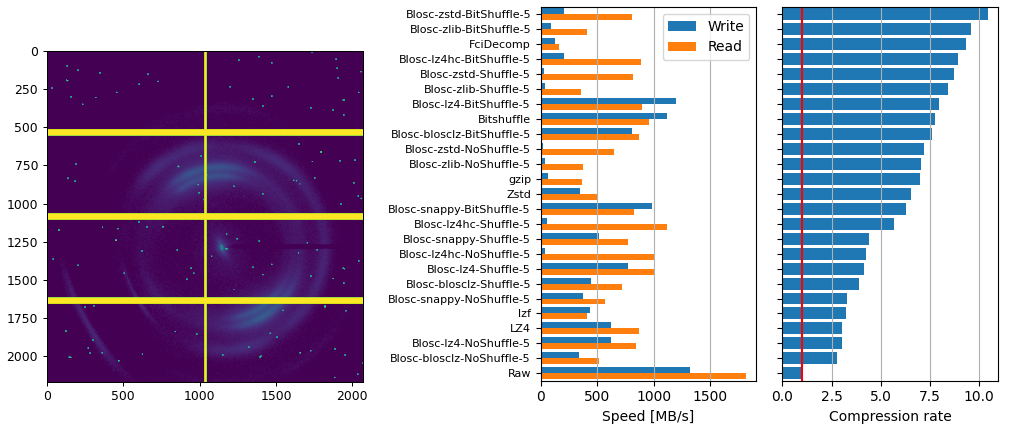 "Benchmark")

#### Multithreaded filter execution

Some filters can use multithreading:

- Blosc:
  - Using a pool of threads
  - Disabled by default
  - Configurable with the `BLOSC_NTHREADS` environment variable
- Bitshuffle, ZFP:
  - Using OpenMP
  - Enabled at compilation time
  - If enabled, configurable with `OMP_NUM_THREADS` environment variable


### Summary

Having different pre-compression filters and compression algorithms at hand offer different read/write speed versus compression rate (and eventually error rate) trade-offs.

Also to keep in mind availability/compatibility: `"gzip"` as included in `libHDF5` is the most compatible one (and also `"lzf"` as included in `h5py`).

## Using `hdf5plugin` filters with other applications

Set the `HDF5_PLUGIN_PATH` environment variable to: `hdf5plugin.PLUGINS_PATH`

In [18]:
%%bash
export HDF5_PLUGIN_PATH=`python3 -c "
import hdf5plugin; print(hdf5plugin.PLUGINS_PATH)"`
echo "HDF5_PLUGIN_PATH=${HDF5_PLUGIN_PATH}"
ls ${HDF5_PLUGIN_PATH}

HDF5_PLUGIN_PATH=/venv/ub20.04/lib/python3.8/site-packages/hdf5plugin/plugins
libh5blosc.so
libh5bshuf.so
libh5fcidecomp.so
libh5lz4.so
libh5zfp.so
libh5zstd.so


**Note**: Only works for reading compressed datasets, **not for writing!**

## A word about `hdf5plugin` license

The source code of `hdf5plugin` itself is licensed under the [MIT](https://github.com/silx-kit/hdf5plugin/blob/main/LICENSE) license...

It also embeds the source code of the provided compression filters and libraries which are licensed under [different open-source licenses](http://www.silx.org/doc/hdf5plugin/latest/information.html#license) (Apache, BSD-2, BSD-3, MIT, Zlib...) and copyrights.

## Limitations

Some limitations of current HDF5 compression filters:
- Compressed data accessed by "chunks" even if compressor uses smaller blocks
- Multi-threaded access
- When reading compressed data, some memory copy could be spared
- Need to link filters with libhdf5
- Only "gzip" available by default and no central repository for registered filters


## Comments

- Direct chunk access offers a way to improve performance/flexibility, at the expense of more code on the user side

- `hdf5plugin` relies on a "hack" to ease the installation of HDF5 compression for Python environments

- Most of the compression filters provided by `hdf5plugin` are included in [blosc](https://github.com/blosc/c-blosc) (or [blosc-2](https://github.com/blosc/c-blosc2))

## Idea: HDF5+Blosc(2)?

- Time for an upgrade of compression support in HDF5?
- What about making blosc(2) available by default in libhdf5?

# Conlusion

`hdf5plugin` provides additional HDF5 compression filters (namely: `Bitshuffle`, `Blosc`, `FciDecomp`, `LZ4`, `ZFP`, `Zstandard`) mainly for use with [h5py](https://docs.h5py.org/).

- Packaged for [**pip**](https://pypi.org/project/hdf5plugin/) and [**conda**](https://anaconda.org/conda-forge/hdf5plugin)
- Documentation: http://www.silx.org/doc/hdf5plugin/latest/
- Source code repository: https://github.com/silx-kit/hdf5plugin

**Credits to hdf5plugin** [**contributors**](https://github.com/silx-kit/hdf5plugin/graphs/contributors): [Thomas Vincent](https://github.com/t20100), [Armando Sole](https://github.com/vasole), [Mark Kittisopikul](https://github.com/mkitti), [\@Florian-toll](https://github.com/Florian-toll), [Jerome Kieffer](https://github.com/kif), [\@fpwg](https://github.com/fpwg), [\@Anthchirp](https://github.com/Anthchirp), [\@mobiusklein](https://github.com/mobiusklein), [\@junyuewang](https://github.com/junyuewang)
**and to all contributors of embedded libraries.**

Partially funded by the [PaNOSC](https://www.panosc.eu/) EU-project.

<img align="left" vertical-align="top" src="data:image/svg+xml,%3Csvg%20width%3D%2240.5%22%20height%3D%2227%22%20version%3D%221.1%22%20xmlns%3D%22http%3A%2F%2Fwww.w3.org%2F2000%2Fsvg%22%20xmlns%3Axlink%3D%22http%3A%2F%2Fwww.w3.org%2F1999%2Fxlink%22%3E%3Cdesc%3EEuropean%20flag%3C%2Fdesc%3E%3Cdefs%3E%3Cg%20id%3D%22s%22%3E%3Cg%20id%3D%22c%22%3E%3Cpath%20id%3D%22t%22%20transform%3D%22rotate%2818%203.1569%20-.5%29%22%20d%3D%22m0%200v1h0.5z%22%2F%3E%3Cuse%20transform%3D%22scale%28-1%2C1%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23t%22%2F%3E%3C%2Fg%3E%3Cg%20id%3D%22a%22%3E%3Cuse%20transform%3D%22rotate%2872%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23c%22%2F%3E%3Cuse%20transform%3D%22rotate%28144%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23c%22%2F%3E%3C%2Fg%3E%3Cuse%20transform%3D%22scale%28-1%2C1%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23a%22%2F%3E%3C%2Fg%3E%3C%2Fdefs%3E%3Crect%20width%3D%2240.5%22%20height%3D%2227%22%20fill%3D%22%23039%22%20stroke-width%3D%22.05%22%2F%3E%3Cg%20transform%3D%22matrix%281.5%2C0%2C0%2C1.5%2C20.25%2C13.5%29%22%20fill%3D%22%23fc0%22%3E%3Cuse%20y%3D%22-6%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23s%22%2F%3E%3Cuse%20y%3D%226%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23s%22%2F%3E%3Cg%20id%3D%22l%22%3E%3Cuse%20x%3D%22-6%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23s%22%2F%3E%3Cuse%20transform%3D%22rotate%28216%20-2.3442%20-2.1107%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23s%22%2F%3E%3Cuse%20transform%3D%22rotate%28144%2C-2.1107%2C-2.3442%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23s%22%2F%3E%3Cuse%20transform%3D%22rotate%2872%2C-4.6626%2C-2.0759%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23s%22%2F%3E%3Cuse%20transform%3D%22rotate%2872%20-5.0759%20.5335%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23s%22%2F%3E%3C%2Fg%3E%3Cuse%20transform%3D%22scale%28-1%2C1%29%22%20width%3D%22100%25%22%20height%3D%22100%25%22%20xlink%3Ahref%3D%22%23l%22%2F%3E%3C%2Fg%3E%3C%2Fsvg%3E"/>&nbsp;This project has received funding from the European Union’s Horizon 2020 research and innovation programme under grant agreement No. 823852.

# Thanks for your attention! Questions?